In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np

# internal imports
from tgb.utils.utils import *
from tgb.linkproppred.evaluate import Evaluator
from modules.decoder import LinkPredictorTGNPL
from modules.emb_module import GraphAttentionEmbedding
from modules.msg_func import TGNPLMessage
from modules.msg_agg import MeanAggregator
from modules.neighbor_loader import LastNeighborLoaderTGNPL
from modules.memory_module import TGNPLMemory, StaticMemory
from modules.early_stopping import  EarlyStopMonitor
from modules.hyper_edgebank import HyperEdgeBankPredictor, test_edgebank
from tgb.linkproppred.dataset_pyg import PyGLinkPropPredDataset, PyGLinkPropPredDatasetHyper
from tgnpl import *

# Initialize data and EdgeBank

In [2]:
# recreate args
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
args = Namespace(dataset='tgbl-hypergraph',
                 lr=1e-4,
                 bs=2000,  # use larger batch size since we're not training
                 k_value=10,
                 num_epoch=100,
                 seed=1,
                 mem_dim=100,
                 time_dim=10,
                 emb_dim=100,
                 tolerance=1e-6,
                 patience=100,
                 num_run=1,
                 wandb=False,
                 bipartite=False,
                 memory_name='static',
                 use_inventory=False,
                 debt_penalty=0,
                 consum_rwd=0,
                 gpu=0)
device = torch.device("cpu")

In [3]:
# Initialize dataset - copied from run_experiment() in tgnpl.py
with open(os.path.join(PATH_TO_DATASETS, f"{args.dataset.replace('-', '_')}/{args.dataset}_meta.json"), "r") as f:
    metadata = json.load(f)
# set global data variables
num_nodes = len(metadata["id2entity"])  
num_firms = metadata["product_threshold"]
num_products = num_nodes - num_firms              
dataset = PyGLinkPropPredDatasetHyper(name=args.dataset, root="datasets")
metric = dataset.eval_metric
neg_sampler = dataset.negative_sampler
evaluator = Evaluator(name=args.dataset)

# split into train/val/test
data = dataset.get_TemporalData().to(device)
train_loader = TemporalDataLoader(data[dataset.train_mask], batch_size=args.bs)
val_loader = TemporalDataLoader(data[dataset.val_mask], batch_size=args.bs)
test_loader = TemporalDataLoader(data[dataset.test_mask], batch_size=args.bs)

dataset.load_val_ns()  # load validation negative samples

Dataset tgbl-hypergraph url not found, download not supported yet.
file found, skipping download
Dataset directory is  /lfs/turing1/0/serinac/supply-chains/TGB/tgb/datasets/tgbl_hypergraph
loading processed file


In [4]:
# initialize edgebank, fit on train
edgebank = HyperEdgeBankPredictor(num_firms, num_products, consecutive=True)
train_data = data[dataset.train_mask]
edgebank.fit(train_data.src, train_data.dst, train_data.prod)

Fit on 214674 edges; found 38756 unique


In [5]:
test_edgebank(val_loader, neg_sampler, "val", evaluator, metric, edgebank, use_counts=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 26.48it/s]


0.3399311602115631

In [6]:
test_edgebank(val_loader, neg_sampler, "val", evaluator, metric, edgebank, use_counts=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.49it/s]


0.6819248199462891

# Results from full experiments

In [7]:
def apply_smoothing(x, agg_func=np.mean, before=2, after=2):
    new_x = []
    for i, x_point in enumerate(x):
        before_idx = max(0, i-before)
        after_idx = min(len(x), i+after+1)
        new_x.append(agg_func(x[before_idx:after_idx]))
    return np.array(new_x)

In [8]:
import matplotlib.pyplot as plt 

def plot_train_loss_and_val_mrr(results, smoothing=0, logscale=True):
    fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharex=True)
    fig.subplots_adjust(wspace=0.3)
    ax = axes[0]
    loss = results['train loss']
    ax.plot(loss)
    if smoothing > 0:
        ax.plot(apply_smoothing(loss, before=smoothing, after=smoothing), label='smoothed')
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Train loss', fontsize=12)
    if logscale:
        ax.set_yscale('symlog')
    ax.grid(alpha=0.2)

    ax = axes[1]
    mrr = results['val mrr']
    ax.plot(mrr)
    if smoothing:
        mrr = ax.plot(apply_smoothing(mrr, before=smoothing, after=smoothing), label='smoothed')
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Val MRR', fontsize=12)
    ax.grid(alpha=0.2)
    return fig, axes

First test mrr = 0.3723, second test mrr = 0.3809
Total num epochs 1000
Min train loss = 1.1642, best val mrr = 0.4006 (epoch 515, train loss = 1.1642)


Text(0.5, 0.98, 'GNN + static memory, cross-entropy')

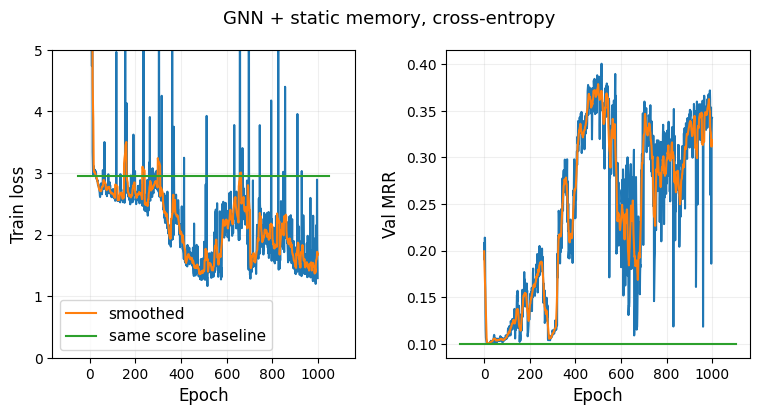

In [25]:
# static memory, softmax cross-entropy loss, 18 random negative samples, 500 epochs (no early stopping)
# command:
# nohup python -u tgnpl.py --time_dim 10 --memory_name static --num_epoch 500 --patience 500 --lr 0.0003 > static_experiment.out 2>&1 &
fn = 'TGNPL_tgbl-hypergraph_0.0003_200_10_500_1_100_10_100_1e-06_500.0_1_False_False_static_False_0_0_0_2023_09_10-20_50_47_results.json'
fn = os.path.join('saved_results', fn)
with open(fn, 'r') as f:
    results1 = json.load(f)[-1]
    
# ran for 500 more epochs, initialized with previous experiment's best weights
# command:
# nohup python -u tgnpl.py --time_dim 10 --memory_name static --num_epoch 500 --patience 500 --lr 0.0003 --weights TGNPL_tgbl-hypergraph_0.0003_200_10_500_1_100_10_100_1e-06_500.0_1_False_False_static_False_0_0_0_2023_09_10-20_50_47_0.pth > static_experiment_ctd.out 2>&1 &
fn = 'TGNPL_tgbl-hypergraph_0.0003_200_10_500_1_100_10_100_1e-06_500.0_1_False_False_static_False_0_0_0_TGNPL_tgbl-hypergraph_0.0003_200_10_500_1_100_10_100_1e-06_500.0_1_False_False_static_False_0_0_0_2023_09_10-20_50_47_0.pth_2023_09_14-11_57_46_results.json'
fn = os.path.join('saved_results', fn)
with open(fn, 'r') as f:
    results2 = json.load(f)
    
print('First test mrr = %.4f, second test mrr = %.4f' % (results1['test mrr'], results2['test mrr']))
results = {'train loss': results1['train loss'] + results2['train loss'],
           'val mrr': results1['val mrr'] + results2['val mrr'],
           'test mrr': results1['test mrr']}
train_loss, val_mrr, test_mrr = results['train loss'], results['val mrr'], results['test mrr']
print('Total num epochs', len(train_loss))
print('Min train loss = %.4f, best val mrr = %.4f (epoch %d, train loss = %.4f)' % (
    min(train_loss), max(val_mrr), np.argmax(val_mrr), train_loss[np.argmax(val_mrr)]))

fig, axes = plot_train_loss_and_val_mrr(results, smoothing=5, logscale=False)
baseline = torch.nn.CrossEntropyLoss()(torch.ones(1, 19), torch.tensor([0]))
axes[0].plot(axes[0].get_xlim(), [baseline, baseline], label='same score baseline')
axes[0].set_ylim(0, 5)
axes[0].legend(loc='lower left', fontsize=11)
axes[1].plot(axes[1].get_xlim(), [0.1, 0.1], label='same score baseline')
fig.suptitle('GNN + static memory, cross-entropy', fontsize=13)

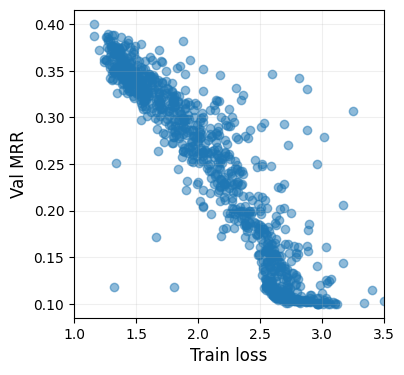

In [16]:
# compare train loss and val mrr
plt.figure(figsize=(4,4))
plt.scatter(results['train loss'][10:], results['val mrr'][10:], alpha=0.5)
plt.xlabel('Train loss', fontsize=12)
plt.ylabel('Val MRR', fontsize=12)
plt.xlim(1, 3.5)
plt.grid(alpha=0.2)

In [17]:
from scipy.stats import pearsonr 

tr = np.array(results['train loss'])
val = np.array(results['val mrr'])
print('All epochs', pearsonr(tr, val))
keep = tr < 3
print(keep.sum()/len(tr))
print('All epochs, tr < 3', pearsonr(tr[keep], val[keep]))

All epochs PearsonRResult(statistic=-0.03203155814835888, pvalue=0.3115765054849065)
0.944
All epochs, tr < 3 PearsonRResult(statistic=-0.9247579691479946, pvalue=0.0)


Total num epochs 352
Min train loss = 2.1775, best val mrr = 0.2475 (epoch 8, train loss = 722.2569), test mrr = -1.0000
[2.27458364 2.27707945 2.28002233 2.29775319 2.30261146 2.31074171
 2.30663907 2.31458418 2.32125305 2.33567235 2.34287703 2.36022591
 2.36386233 2.36510932 2.354077   2.36141221 2.35852877 2.35304813
 2.3487047  2.34419892 2.33918297 2.34467858 2.3424496  2.34333444
 2.3366027  2.33708153 2.3269533  2.33019877 2.33989788 2.3431695 ]


Text(0.5, 0.98, 'GNN + static memory, cross-entropy')

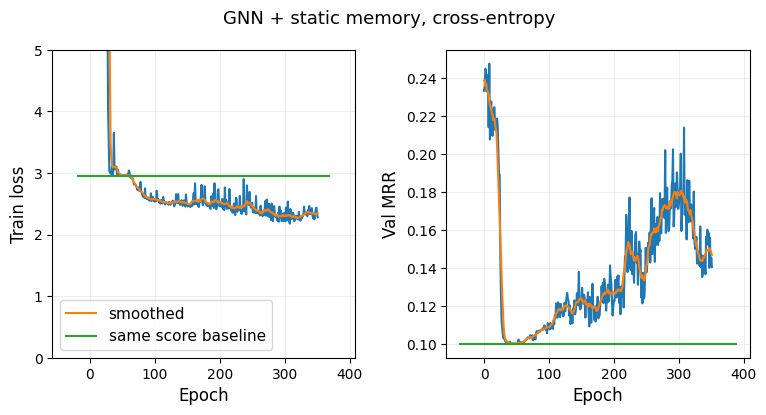

In [26]:
# same experiment but with lower (default) learning rate of 0.0001
# command:
# nohup python -u tgnpl.py --time_dim 10 --memory_name static --num_epoch 500 --patience 500 --gpu 1 > static_experiment_lr.out 2>&1 &
fn = 'TGNPL_tgbl-hypergraph_0.0001_200_10_500_1_100_10_100_1e-06_500.0_1_False_False_static_False_0_0_1__2023_09_15-09_02_18_results.json'
fn = os.path.join('saved_results', fn)
with open(fn, 'r') as f:
    results = json.load(f)
train_loss, val_mrr, test_mrr = results['train loss'], results['val mrr'], results.get('test mrr', -1)
print('Total num epochs', len(train_loss))
print('Min train loss = %.4f, best val mrr = %.4f (epoch %d, train loss = %.4f), test mrr = %.4f' % (
    min(train_loss), max(val_mrr), np.argmax(val_mrr), train_loss[np.argmax(val_mrr)], test_mrr))

print(apply_smoothing(results['train loss'], before=5, after=5)[-30:])
fig, axes = plot_train_loss_and_val_mrr(results, smoothing=5, logscale=False)
baseline = torch.nn.CrossEntropyLoss()(torch.ones(1, 19), torch.tensor([0]))
axes[0].plot(axes[0].get_xlim(), [baseline, baseline], label='same score baseline')
axes[0].set_ylim(0, 5)
axes[0].legend(loc='lower left', fontsize=11)
axes[1].plot(axes[1].get_xlim(), [0.1, 0.1], label='same score baseline')
fig.suptitle('GNN + static memory, cross-entropy', fontsize=13)

In [27]:
from scipy.stats import pearsonr 

tr = np.array(results['train loss'])
val = np.array(results['val mrr'])
print('All epochs', pearsonr(tr, val))
keep = tr < 3
print(keep.sum()/len(tr))
print('All epochs, tr < 3', pearsonr(tr[keep], val[keep]))

All epochs PearsonRResult(statistic=0.5607372965810364, pvalue=1.540496466852236e-30)
0.8778409090909091
All epochs, tr < 3 PearsonRResult(statistic=-0.7963432817313217, pvalue=5.258106489987849e-69)


Min train loss = 2.0597, best val mrr = 0.2331 (train loss = 944.9884), test mrr = 0.2287


Text(0.5, 0.98, 'GNN + static memory')

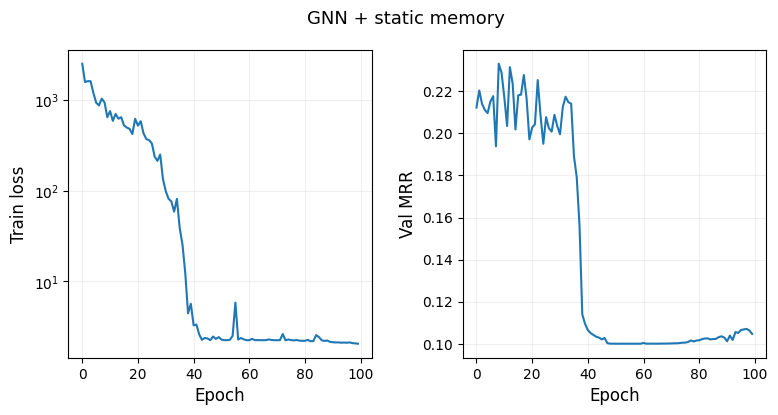

In [30]:
# old experiment
# static, mostly default settings, BCE criterion
fn = 'TGNPL_tgbl-hypergraph_0.0001_200_10_100_1_100_10_100_1e-06_100.0_1_10_static_False_0_0_2023_09_05-14_14_02_results.json'
fn = os.path.join('saved_results', fn)
with open(fn, 'r') as f:
    results = json.load(f)
train_loss, val_mrr, test_mrr = results['train loss'], results['val mrr'], results['test mrr']
print('Min train loss = %.4f, best val mrr = %.4f (train loss = %.4f), test mrr = %.4f' % (
    min(train_loss), max(val_mrr), train_loss[np.argmax(val_mrr)], test_mrr))
fig, axes = plot_train_loss_and_val_mrr(results)
fig.suptitle('GNN + static memory', fontsize=13)

## What did the model learn?

In [8]:
# Initialize model and neighbor_loader
model, opt = set_up_model(args, data, device, num_nodes=num_nodes, num_products=num_products)
neighbor_loader = LastNeighborLoaderTGNPL(num_nodes, size=NUM_NEIGHBORS, device=device)

### Try final model with low train loss

In [7]:
# load saved model - final model with low training loss
model_path = 'TGNPL_tgbl-hypergraph_0.0001_200_10_100_1_100_10_100_1e-06_100.0_1_10_static_False_0_0_2023_09_05-14_14_02_0_final.pth'
model_path = os.path.join('saved_models', model_path)
checkpoint = torch.load(model_path)
for module_name, module in model.items():
    module.load_state_dict(checkpoint[module_name])

In [8]:
# run the model through train loader *without* updating model weights
# this is so that we can update model memory and neighbor loader with train data
# and to verify that the train loss is low
train(model, _, neighbor_loader, data, train_loader, device, loss_name='bce-logits',
      update_params=False, num_nodes=num_nodes, num_firms=num_firms, num_products=num_products)

100%|███████████████████████████████████████████████████████████████████████| 108/108 [01:20<00:00,  1.35it/s]


(2.2241699868197795, 2.2241699868197795, 0.0)

In [10]:
# test model on first batch of val loader
# copied from test() in tgnpl.py
model['memory'].eval()
model['gnn'].eval()
model['link_pred'].eval()
assoc = torch.empty(num_nodes, dtype=torch.long, device=device)

pos_batch = next(iter(val_loader))
pos_src, pos_prod, pos_dst, pos_t, pos_msg = (
    pos_batch.src,
    pos_batch.prod,
    pos_batch.dst,
    pos_batch.t,
    pos_batch.msg,
)
bs = len(pos_src)  # batch size

neg_batch_list = neg_sampler.query_batch(pos_src, pos_prod, pos_dst, pos_t, split_mode='val')
assert len(neg_batch_list) == bs
neg_batch_list = torch.Tensor(neg_batch_list)
ns_samples = neg_batch_list.size(1) // 3 
batch_src = pos_src.reshape(bs, 1).repeat(1, 1+(3*ns_samples))  # [[src1, src1, ...], [src2, src2, ...]]
batch_src[:, 1:ns_samples+1] = neg_batch_list[:, :ns_samples]  # replace pos_src with negatives
batch_prod = pos_prod.reshape(bs, 1).repeat(1, 1+(3*ns_samples))
batch_prod[:, ns_samples+1:(2*ns_samples)+1] = neg_batch_list[:, ns_samples:(2*ns_samples)]  # replace pos_prod with negatives
batch_dst = pos_dst.reshape(bs, 1).repeat(1, 1+(3*ns_samples))
batch_dst[:, (2*ns_samples)+1:] = neg_batch_list[:, (2*ns_samples):]  # replace pos_dst with negatives
src, dst, prod = batch_src.flatten(), batch_dst.flatten(), batch_prod.flatten()  # row-wise

# Get GNN prediction
f_id = torch.cat([src, dst]).unique()
p_id = torch.cat([prod]).unique()
n_id, edge_index, e_id = neighbor_loader(f_id, p_id)
assoc[n_id] = torch.arange(n_id.size(0), device=device)
# Get updated memory of all nodes involved in the computation.
memory, last_update, inv_loss = model['memory'](n_id)
z = model['gnn'](
    memory,
    last_update,
    edge_index,
    repeat_tensor(data.t, 2)[e_id].to(device),
    repeat_tensor(data.msg, 2)[e_id].to(device),
)
y_pred_gnn = model['link_pred'](z[assoc[src]], z[assoc[dst]], z[assoc[prod]])
y_pred = y_pred_gnn.reshape(bs, 1+(3*ns_samples))
input_dict = {
    "y_pred_pos": y_pred[:, :1],
    "y_pred_neg": y_pred[:, 1:],
    "eval_metric": [metric]
}
print('GNN MRR:', evaluator.eval(input_dict)[metric])

# Get Edgebank prediction
y_pred_eb = edgebank.predict(src, dst, prod, use_counts=True)
y_pred = y_pred_eb.reshape(bs, 1+(3*ns_samples))
input_dict = {
    "y_pred_pos": y_pred[:, :1],
    "y_pred_neg": y_pred[:, 1:],
    "eval_metric": [metric]
}
print('EdgeBank MRR:', evaluator.eval(input_dict)[metric])

GNN MRR: 0.104181096
EdgeBank MRR: 0.69496816


In [11]:
from scipy.stats import spearmanr

y_pred_gnn = y_pred_gnn.detach().numpy()
y_pred_eb = y_pred_eb.detach().numpy()
print(y_pred_gnn.shape)
print('Spearman correlation', spearmanr(y_pred_gnn, y_pred_eb))
print(y_pred_gnn[:10])

(38000, 1)
Spearman correlation SpearmanrResult(correlation=0.0576111721834171, pvalue=2.610014425769743e-29)
[[-0.8352514]
 [-0.8352514]
 [-0.8352514]
 [-0.8352514]
 [-0.8352514]
 [-0.8352514]
 [-0.8352514]
 [-0.8352514]
 [-0.8352514]
 [-0.8352514]]


In [12]:
y_pred_eb[:10]

array([11.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,  1.], dtype=float32)

### Try best model with highest val MRR

In [13]:
# load saved model - model with highest MRR
model_path = 'TGNPL_tgbl-hypergraph_0.0001_200_10_100_1_100_10_100_1e-06_100.0_1_10_static_False_0_0_2023_09_05-14_14_02_0.pth'
model_path = os.path.join('saved_models', model_path)
checkpoint = torch.load(model_path)
for module_name, module in model.items():
    module.load_state_dict(checkpoint[module_name])

In [14]:
# run the model through train loader *without* updating model weights
# this is so that we can update model memory and neighbor loader with train data
# and to verify that the train loss is much higher
train(model, _, neighbor_loader, data, train_loader, device, loss_name='bce-logits',
      update_params=False, num_nodes=num_nodes, num_firms=num_firms, num_products=num_products)

100%|███████████████████████████████████████████████████████████████████████| 108/108 [01:33<00:00,  1.16it/s]


(345.256700752653, 345.256700752653, 0.0)

In [15]:
# Get GNN prediction
f_id = torch.cat([src, dst]).unique()
p_id = torch.cat([prod]).unique()
n_id, edge_index, e_id = neighbor_loader(f_id, p_id)
assoc[n_id] = torch.arange(n_id.size(0), device=device)
# Get updated memory of all nodes involved in the computation.
memory, last_update, inv_loss = model['memory'](n_id)
z = model['gnn'](
    memory,
    last_update,
    edge_index,
    repeat_tensor(data.t, 2)[e_id].to(device),
    repeat_tensor(data.msg, 2)[e_id].to(device),
)
y_pred_gnn = model['link_pred'](z[assoc[src]], z[assoc[dst]], z[assoc[prod]])
y_pred = y_pred_gnn.reshape(bs, 1+(3*ns_samples))
input_dict = {
    "y_pred_pos": y_pred[:, :1],
    "y_pred_neg": y_pred[:, 1:],
    "eval_metric": [metric]
}
print('GNN MRR:', evaluator.eval(input_dict)[metric])  # should be higher than before

# Get Edgebank prediction
y_pred_eb = edgebank.predict(src, dst, prod, use_counts=True)
y_pred = y_pred_eb.reshape(bs, 1+(3*ns_samples))
input_dict = {
    "y_pred_pos": y_pred[:, :1],
    "y_pred_neg": y_pred[:, 1:],
    "eval_metric": [metric]
}
print('EdgeBank MRR:', evaluator.eval(input_dict)[metric])  # should be the same as before

GNN MRR: 0.22699822
EdgeBank MRR: 0.69496816


In [16]:
from scipy.stats import spearmanr

y_pred_gnn = y_pred_gnn.detach().numpy()
y_pred_eb = y_pred_eb.detach().numpy()
print(y_pred_gnn.shape)
print('Spearman correlation', spearmanr(y_pred_gnn, y_pred_eb))
print(y_pred_gnn[:10])

(38000, 1)
Spearman correlation SpearmanrResult(correlation=0.16916034598167873, pvalue=6.769444725066205e-242)
[[-1406.6364 ]
 [-2458.574  ]
 [-2461.6873 ]
 [-1911.2262 ]
 [-2617.1443 ]
 [-2453.531  ]
 [-2464.6873 ]
 [-1370.6754 ]
 [-1371.9606 ]
 [ -726.79846]]


### Test loss

In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = -0.8352514
sigx = sigmoid(x)
print('sigmoid x:', sigx)

pos_l = -np.log(sigx)
print('loss if positive', pos_l)

neg_l = -np.log(1-sigx)
print('loss if negative', neg_l)

total = pos_l + (3*neg_l)
print('expected total loss from batch', total)

sigmoid x: 0.30253583558385383
loss if positive 1.1955555437876215
loss if negative 0.36030414378762143
expected total loss from batch 2.276467975150486


In [9]:
ce_loss = torch.nn.CrossEntropyLoss()
ce_loss(torch.tensor([[x, x, x, x]]), torch.tensor([0]).long())

tensor(1.3863)

In [10]:
# same if you use any equal number
ce_loss(torch.ones((1, 4)), torch.tensor([0]).long())

tensor(1.3863)

In [26]:
for c in range(4, 20):
    print(c, ce_loss(torch.ones((1, c)), torch.tensor([0]).long()))

4 tensor(1.3863)
5 tensor(1.6094)
6 tensor(1.7918)
7 tensor(1.9459)
8 tensor(2.0794)
9 tensor(2.1972)
10 tensor(2.3026)
11 tensor(2.3979)
12 tensor(2.4849)
13 tensor(2.5649)
14 tensor(2.6391)
15 tensor(2.7081)
16 tensor(2.7726)
17 tensor(2.8332)
18 tensor(2.8904)
19 tensor(2.9444)


In [27]:
# double, four classes
ce_loss(torch.tensor([[2., 1., 1., 1.]]), torch.tensor([0]).long())

tensor(0.7437)

In [28]:
# half, four classes
ce_loss(torch.tensor([[0.5, 1., 1., 1.]]), torch.tensor([0]).long())

tensor(1.7827)

### Try final model from cross-entropy experiment

In [32]:
# load saved model
model_path = 'TGNPL_tgbl-hypergraph_0.0001_200_10_100_1_100_10_100_1e-06_100.0_1_10_static_False_0_0_2023_09_06-11_46_26_0_final.pth'
model_path = os.path.join('saved_models', model_path)
checkpoint = torch.load(model_path)
for module_name, module in model.items():
    module.load_state_dict(checkpoint[module_name])

In [33]:
# run the model through train loader *without* updating model weights
# this is so that we can update model memory and neighbor loader with train data
# and to verify that the train loss is much higher
train(model, _, neighbor_loader, data, train_loader, device, loss_name='ce-softmax',
      update_params=False, num_nodes=num_nodes, num_firms=num_firms, num_products=num_products)

100%|███████████████████████████████████████████████████████████████████████| 108/108 [01:11<00:00,  1.51it/s]


(1.3821909806848687, 1.3821909806848687, 0.0)

In [34]:
# Get GNN prediction
f_id = torch.cat([src, dst]).unique()
p_id = torch.cat([prod]).unique()
n_id, edge_index, e_id = neighbor_loader(f_id, p_id)
assoc[n_id] = torch.arange(n_id.size(0), device=device)
# Get updated memory of all nodes involved in the computation.
memory, last_update, inv_loss = model['memory'](n_id)
z = model['gnn'](
    memory,
    last_update,
    edge_index,
    repeat_tensor(data.t, 2)[e_id].to(device),
    repeat_tensor(data.msg, 2)[e_id].to(device),
)
y_pred_gnn = model['link_pred'](z[assoc[src]], z[assoc[dst]], z[assoc[prod]])
y_pred = y_pred_gnn.reshape(bs, 1+(3*ns_samples))
input_dict = {
    "y_pred_pos": y_pred[:, :1],
    "y_pred_neg": y_pred[:, 1:],
    "eval_metric": [metric]
}
print('GNN MRR:', evaluator.eval(input_dict)[metric])  # should be higher than before

# Get Edgebank prediction
y_pred_eb = edgebank.predict(src, dst, prod, use_counts=True)
y_pred = y_pred_eb.reshape(bs, 1+(3*ns_samples))
input_dict = {
    "y_pred_pos": y_pred[:, :1],
    "y_pred_neg": y_pred[:, 1:],
    "eval_metric": [metric]
}
print('EdgeBank MRR:', evaluator.eval(input_dict)[metric])  # should be the same as before

GNN MRR: 0.1001942
EdgeBank MRR: 0.69496816


In [35]:
from scipy.stats import spearmanr

y_pred_gnn = y_pred_gnn.detach().numpy()
y_pred_eb = y_pred_eb.detach().numpy()
print(y_pred_gnn.shape)
print('Spearman correlation', spearmanr(y_pred_gnn, y_pred_eb))
print(y_pred_gnn[:10])

(38000, 1)
Spearman correlation SpearmanrResult(correlation=0.023991311286992563, pvalue=2.9069547426294575e-06)
[[-1.9877135]
 [-1.9877135]
 [-1.9877135]
 [-1.9877135]
 [-1.9877135]
 [-1.9877135]
 [-1.9877135]
 [-1.9877135]
 [-1.9877135]
 [-1.9877135]]


In [36]:
y_pred_eb[:10]

array([11.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,  1.], dtype=float32)

# Try fitting model on tiny data

In [9]:
# first 100 data points in val, NO neighbors
mini_loader = TemporalDataLoader(data[dataset.val_mask][:100], batch_size=args.bs)
assert len(mini_loader) == 1
batch = next(iter(mini_loader))
pos_src, pos_prod, pos_dst, pos_t, pos_msg = batch.src, batch.prod, batch.dst, batch.t, batch.msg
print(pos_src.shape)

torch.Size([100])


In [10]:
# try model with static memory
model, opt = set_up_model(args, data, device, num_firms=num_firms, num_products=num_products)
neighbor_loader = LastNeighborLoaderTGNPL(num_nodes, size=NUM_NEIGHBORS, device=device)

# fit model on FIXED negative samples from neg_sampler
for epoch in range(1, 1000):
    loss, _, _ = train(model, opt, neighbor_loader, data, mini_loader, device, 
                       loss_name='ce-softmax', update_params=True, 
                       neg_sampler=neg_sampler, split_mode="val", 
                       num_firms=num_firms, num_products=num_products)
    if epoch % 10 == 0:
        print(epoch, loss)

10 2.9220187664031982
20 2.9017345905303955
30 2.880199670791626
40 2.8553457260131836
50 2.8263094425201416
60 2.7912774085998535
70 2.747941255569458
80 2.6948401927948
90 2.6300723552703857
100 2.551215171813965
110 2.4560129642486572
120 2.3421247005462646
130 2.2077460289001465
140 2.054453134536743
150 1.8853542804718018
160 1.7037063837051392
170 1.515998363494873
180 1.3258295059204102
190 1.141403317451477
200 0.9695330858230591
210 0.8153750896453857
220 0.6815702319145203
230 0.5684295296669006
240 0.4747850298881531
250 0.3986516296863556
260 0.33613598346710205
270 0.2851008474826813
280 0.24368907511234283
290 0.20917189121246338
300 0.18004654347896576
310 0.15600349009037018
320 0.13607057929039001
330 0.11928333342075348
340 0.10512791574001312
350 0.09318291395902634
360 0.08297906070947647
370 0.07427482306957245
380 0.06677387654781342
390 0.06023601070046425
400 0.054511502385139465
410 0.04945424944162369
420 0.044879134744405746
430 0.040811337530612946
440 0.037

In [11]:
# test MRR on same data
# if we don't reset neighbor loader, results will be bad
test(model, neighbor_loader, data, mini_loader, neg_sampler, evaluator, device,
     split_mode="val", metric="mrr", num_firms=num_firms, num_products=num_products)

0.06897573918104172

In [12]:
# perfect results once we reset
neighbor_loader.reset_state()
test(model, neighbor_loader, data, mini_loader, neg_sampler, evaluator, device,
     split_mode="val", metric="mrr", num_firms=num_firms, num_products=num_products)

1.0

In [13]:
# still trying model with static memory
model, opt = set_up_model(args, data, device, num_firms=num_firms, num_products=num_products)
neighbor_loader = LastNeighborLoaderTGNPL(num_nodes, size=NUM_NEIGHBORS, device=device)

# fit model on RANDOM negative samples
# should be able to learn but loss will go down a bit more randomly
for epoch in range(1, 1000):
    loss, _, _ = train(model, opt, neighbor_loader, data, mini_loader, device, 
                       loss_name='ce-softmax', update_params=True, 
                       ns_samples=6, num_firms=num_firms, num_products=num_products)
    if epoch % 10 == 0:
        print(epoch, loss)

10 2.930971145629883
20 2.9115118980407715
30 2.891180992126465
40 2.8688530921936035
50 2.842466354370117
60 2.8105926513671875
70 2.7741265296936035
80 2.7234182357788086
90 2.670279026031494
100 2.606276750564575
110 2.523387908935547
120 2.4261014461517334
130 2.320310592651367
140 2.176255941390991
150 2.048274278640747
160 1.8960990905761719
170 1.7060673236846924
180 1.5425710678100586
190 1.3795925378799438
200 1.1849300861358643
210 1.080944538116455
220 0.9391130208969116
230 0.8780184388160706
240 0.7507911920547485
250 0.6481524705886841
260 0.5959666967391968
270 0.5392009019851685
280 0.43563270568847656
290 0.41123539209365845
300 0.3986228108406067
310 0.35086485743522644
320 0.28176915645599365
330 0.35280081629753113
340 0.316967636346817
350 0.24492065608501434
360 0.32185104489326477
370 0.31544309854507446
380 0.2739083766937256
390 0.27624624967575073
400 0.26546764373779297
410 0.22075535356998444
420 0.21114473044872284
430 0.23568663001060486
440 0.223344326019

In [14]:
# test MRR on same data
# if we don't reset neighbor loader, results will be bad
mrr1 = test(model, neighbor_loader, data, mini_loader, neg_sampler, evaluator, device,
     split_mode="val", metric="mrr", num_firms=num_firms, num_products=num_products)

# much better results once we reset
neighbor_loader.reset_state()
mrr2 = test(model, neighbor_loader, data, mini_loader, neg_sampler, evaluator, device,
     split_mode="val", metric="mrr", num_firms=num_firms, num_products=num_products)

print(f'MRR: before resetting = {mrr1:.4f}; after resetting = {mrr2:.4f}')

MRR: before resetting = 0.0766; after resetting = 0.8275


In [15]:
# first 100 data points in val, WITH time-varying neighbors
mini_loader = TemporalDataLoader(data[dataset.val_mask][:100], batch_size=10)
print(len(mini_loader))
batch = next(iter(mini_loader))
pos_src, pos_prod, pos_dst, pos_t, pos_msg = batch.src, batch.prod, batch.dst, batch.t, batch.msg
print(pos_src.shape)

10
torch.Size([10])


In [16]:
# still trying model with static memory
model, opt = set_up_model(args, data, device, num_firms=num_firms, num_products=num_products)
neighbor_loader = LastNeighborLoaderTGNPL(num_nodes, size=NUM_NEIGHBORS, device=device)

# fit model on FIXED negative samples from neg_sampler, time-varying neighbors
# results: loss seems a lot more unstable with time-varying neighbors
for epoch in range(1, 1000):
    loss, _, _ = train(model, opt, neighbor_loader, data, mini_loader, device, 
                       loss_name='ce-softmax', update_params=True, 
                       neg_sampler=neg_sampler, split_mode="val", 
                       num_firms=num_firms, num_products=num_products)
    if epoch % 10 == 0:
        print(epoch, loss)

10 27.83467755317688
20 25.512652802467347
30 17.72217490673065
40 9.773334860801697
50 12.475264048576355
60 18.38878974914551
70 6.673036909103393
80 16.780718970298768
90 35.1246514081955
100 13.547952389717102
110 36.498050117492674
120 22.376689910888672
130 17.23010218143463
140 16.06598675251007
150 11.117098689079285
160 7.550931918621063
170 35.25904347896576
180 16.91236913204193
190 17.091584753990173
200 21.56358560323715
210 8.307183039188384
220 9.269250357151032
230 32.50069929361344
240 19.948943161964415
250 22.00958843231201
260 11.412116718292236
270 28.59958282709122
280 10.828151714801788
290 8.165119385719299
300 19.106104099750517
310 8.442838144302367
320 14.171113383769988
330 14.392888021469116
340 12.668455427885055
350 9.190313917398452
360 19.574453008174896
370 8.777259993553162
380 6.195041143894196
390 19.86347241103649
400 22.268221825361252
410 4.114210107922554
420 4.014375162124634
430 7.906044036149979
440 5.86535621881485
450 14.850204120576382
460

In [17]:
# test MRR on same data
# if we don't reset neighbor loader, results will be bad
mrr1 = test(model, neighbor_loader, data, mini_loader, neg_sampler, evaluator, device,
     split_mode="val", metric="mrr", num_firms=num_firms, num_products=num_products)

# even with unstable loss, MRR is quite high!
neighbor_loader.reset_state()
mrr2 = test(model, neighbor_loader, data, mini_loader, neg_sampler, evaluator, device,
     split_mode="val", metric="mrr", num_firms=num_firms, num_products=num_products)

print(f'MRR: before resetting = {mrr1:.4f}; after resetting = {mrr2:.4f}')

MRR: before resetting = 0.3897; after resetting = 0.9201


In [18]:
# still trying model with static memory
model, opt = set_up_model(args, data, device, num_firms=num_firms, num_products=num_products)
neighbor_loader = LastNeighborLoaderTGNPL(num_nodes, size=NUM_NEIGHBORS, device=device)

# fit model on RANDOM negative samples, time-varying neighbors
# should be able to learn but loss will go down a bit more randomly
for epoch in range(1, 1000):
    loss, _, _ = train(model, opt, neighbor_loader, data, mini_loader, device, 
                       loss_name='ce-softmax', update_params=True, 
                       ns_samples=6, num_firms=num_firms, num_products=num_products)
    if epoch % 10 == 0:
        print(epoch, loss)

10 24.956241965293884
20 30.43052921295166
30 7.695990705490113
40 13.213143491744995
50 98.48384375572205
60 72.1378377199173
70 29.12720568180084
80 70.45835793018341
90 12.57285213470459
100 12.824302053451538
110 10.095746684074403
120 15.348774886131286
130 162.0021781206131
140 4.201750612258911
150 6.744742202758789
160 24.57523732185364
170 5.696411538124084
180 14.870009446144104
190 53.59659504890442
200 8.538229417800903
210 38.080921220779416
220 8.127930772304534
230 26.291881763935088
240 13.497850334644317
250 42.264190673828125
260 28.690243244171143
270 52.675991606712344
280 74.2493488907814
290 60.079473447799685
300 40.80417897701263
310 58.95437757968902
320 15.210980558395386
330 37.40291576385498
340 8.561397051811218
350 16.884440660476685
360 45.48376286625862
370 18.291567957401277
380 7.01245037317276
390 1.964197474718094
400 7.915888142585755
410 6.348958498239517
420 4.519175231456757
430 7.108771502971649
440 5.050497698783874
450 15.848555278778075
460 1

In [19]:
# test MRR on same data
# low cross-entropy loss should correspond to high MRR
# if we don't reset neighbor loader, results will be bad
mrr1 = test(model, neighbor_loader, data, mini_loader, neg_sampler, evaluator, device,
     split_mode="val", metric="mrr", num_firms=num_firms, num_products=num_products)

# results: even with unstable loss, MRR is quite high!
neighbor_loader.reset_state()
mrr2 = test(model, neighbor_loader, data, mini_loader, neg_sampler, evaluator, device,
     split_mode="val", metric="mrr", num_firms=num_firms, num_products=num_products)

print(f'MRR: before resetting = {mrr1:.4f}; after resetting = {mrr2:.4f}')

MRR: before resetting = 0.1831; after resetting = 0.8171


In [32]:
# now try model WITH MEMORY UPDATES, still no inventory
args.memory_name = 'tgnpl'
model, opt = set_up_model(args, data, device, num_firms=num_firms, num_products=num_products)
neighbor_loader = LastNeighborLoaderTGNPL(num_nodes, size=NUM_NEIGHBORS, device=device)

# fit model on FIXED negative samples from neg_sampler
for epoch in range(1, 10000):
    loss, _, _ = train(model, opt, neighbor_loader, data, mini_loader, device, 
                       loss_name='ce-softmax', update_params=True, 
                       neg_sampler=neg_sampler, split_mode="val", 
                       num_firms=num_firms, num_products=num_products)
    if loss < 0.01:
        print(f'Early stopping on epoch {epoch}, loss =', loss)
        break
    if epoch % 10 == 0:
        print(epoch, loss)

311 100
10 21.044700503349304
20 13.277572965621948
30 44.376331901550294
40 26.074535775184632
50 36.28038969039917
60 23.0483519077301
70 34.71280031204223
80 11.13726601600647
90 31.982992911338805
100 63.541959691047666
110 51.641471076011655
120 18.117871856689455
130 51.42816169261933
140 28.130963444709778
150 52.86318504810333
160 28.135871171951294
170 14.516760754585267
180 22.393138194084166
190 34.35323522090912
200 7.773191690444946
210 42.01384627819061
220 35.630638289451596
230 80.64843201637268
240 13.32774043083191
250 26.83047523498535
260 29.928940653800964
270 15.344571352005005
280 26.266888093948364
290 41.380528116226195
300 17.4327721118927
310 47.2945433139801
320 31.48147656917572
330 48.17752730846405
340 24.417616271972655
350 21.85060112476349
360 20.497200322151183
370 41.146926045417786
380 36.93029487133026
390 10.99596610069275
400 59.094158387184144
410 23.157463335990904
420 11.961176013946533
430 5.498515725135803
440 5.291756224632263
450 54.161263

KeyboardInterrupt: 

In [34]:
# check final train loss, don't update model params
loss, _, _ = train(model, opt, neighbor_loader, data, mini_loader, device, 
                   loss_name='ce-softmax', update_params=False, 
                   neg_sampler=neg_sampler, split_mode="val", 
                   num_firms=num_firms, num_products=num_products)
loss

3.3461313247680664

In [35]:
# test MRR on same data
# low cross-entropy loss should correspond to high MRR
# if we don't reset neighbor loader, results will be bad
mrr1 = test(model, neighbor_loader, data, mini_loader, neg_sampler, evaluator, device,
     split_mode="val", metric="mrr", num_firms=num_firms, num_products=num_products)

# results: model performs _worse_ after resetting, weird
model['memory'].reset_state()
neighbor_loader.reset_state()
mrr2 = test(model, neighbor_loader, data, mini_loader, neg_sampler, evaluator, device,
     split_mode="val", metric="mrr", num_firms=num_firms, num_products=num_products)

print(f'MRR: before resetting = {mrr1:.4f}; after resetting = {mrr2:.4f}')

MRR: before resetting = 0.3893; after resetting = 0.1924


In [36]:
loss, _, _ = train(model, opt, neighbor_loader, data, mini_loader, device, 
                   loss_name='ce-softmax', update_params=False, 
                   neg_sampler=neg_sampler, split_mode="val", 
                   num_firms=num_firms, num_products=num_products)
loss

3.3461313247680664

In [37]:
# test MRR on same data
# low cross-entropy loss should correspond to high MRR
# if we don't reset neighbor loader, results will be bad
mrr1 = test(model, neighbor_loader, data, mini_loader, neg_sampler, evaluator, device,
     split_mode="val", metric="mrr", num_firms=num_firms, num_products=num_products)

# results: even with unstable loss, MRR is quite high!
model['memory'].reset_state()
neighbor_loader.reset_state()
mrr2 = test(model, neighbor_loader, data, mini_loader, neg_sampler, evaluator, device,
     split_mode="val", metric="mrr", num_firms=num_firms, num_products=num_products)

print(f'MRR: before resetting = {mrr1:.4f}; after resetting = {mrr2:.4f}')

MRR: before resetting = 0.3893; after resetting = 0.1924
